# SINDy Model Identification on Lorenz System Data

This tutorial demonstrates how to use **SINDy (Sparse Identification of Nonlinear Dynamics)** to discover the governing equations of the Lorenz system directly from noisy data.

The Lorenz system is defined by the following set of three coupled, nonlinear ordinary differential equations:

$$
\begin{align}
\dot{x} &= \sigma(y-x) \\
\dot{y} &= x(\rho-z)-y \\
\dot{z} &= xy - \beta z
\end{align}
$$

Here, $\sigma$, $\rho$, and $\beta$ are system parameters, and $\dot{x}$, $\dot{y}$, and $\dot{z}$ represent the derivatives of the state variables with respect to time.

The tutorial is split into five steps:

- Generate noisy data: integrate the Lorenz system ODE and add Gaussian white noise
- Compute derivatives: using finite difference
- Build the library $\Theta$, here using polynomials up to order 3
- Compute sparse regression
- Evaluate the performance of the identified SINDy model for forecasting


Ensure you have the 'utils.py' file in the same directory, and make sure you have the required libraries installed, e.g. !pip install numpy scipy matplotlib

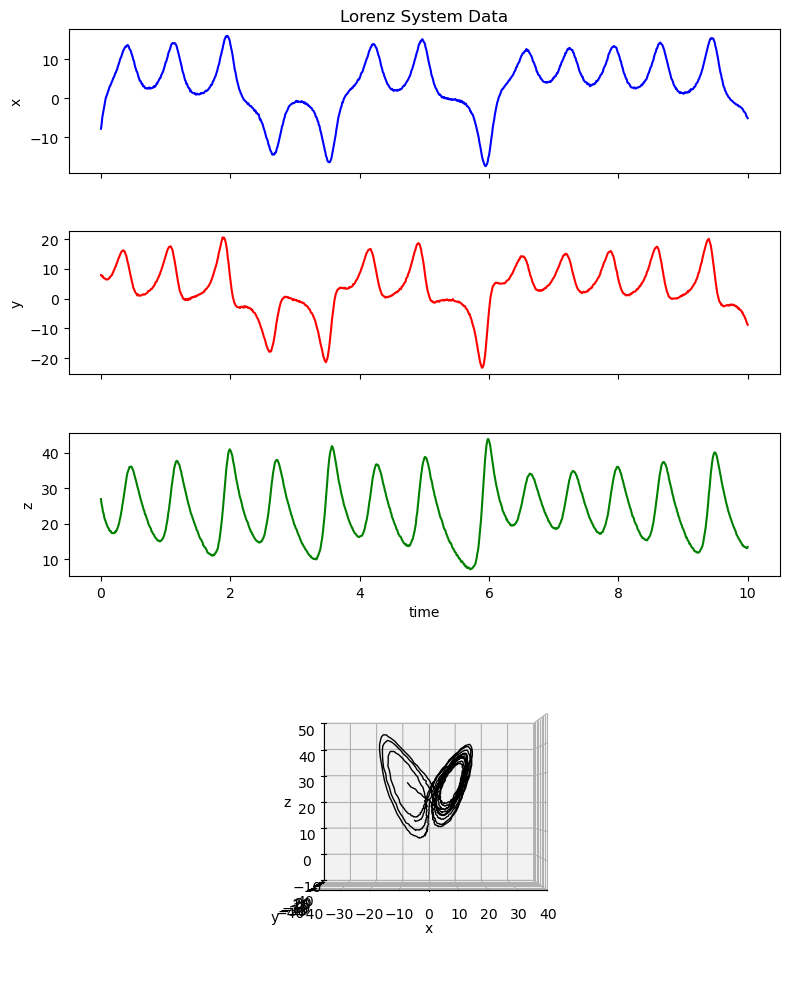

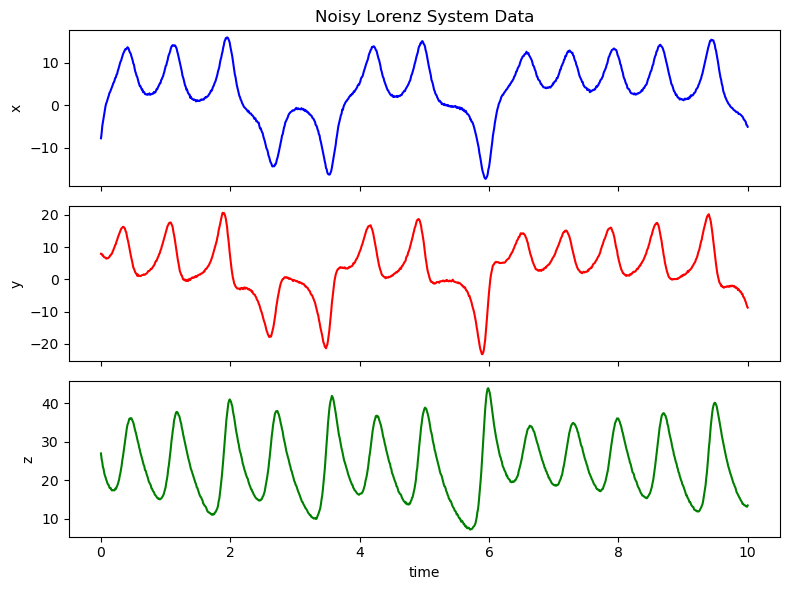

In [7]:
# Import necessary libraries
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from utils import plot_lorenz, plot_sindy, poolData # Import from the utils file

# ------------------------------------------------
# 1. Generate Noisy Lorenz System Data
# ------------------------------------------------

# Lorenz system parameters
sigma, rho, beta = 10, 28, 8/3
params = [sigma, rho, beta]

# Initial conditions x0, time step dt, and time span tspan
x0 = [-8, 8, 27]
dt = 0.01
t_span = (0, 10)
t_eval = np.arange(t_span[0], t_span[1] + dt, dt)

# Lorenz system right-hand side function
def lorenz_system(t, x, params):
    dx = params[0] * (x[1] - x[0])
    dy = x[0] * (params[1] - x[2]) - x[1]
    dz = x[0] * x[1] - params[2] * x[2]
    return [dx, dy, dz]

# Solve the initial value problem 
solution = solve_ivp(
    fun=lorenz_system,
    t_span=t_span,
    y0=x0,
    args=(params,),
    t_eval=t_eval
)
x_true = solution.y.T

# Add Gaussian white noise
np.random.seed(1)
sig = 0.01
x_noisy = x_true + sig * np.std(x_true) * np.random.randn(*x_true.shape)

# Plot the noisy data
plot_lorenz(t_eval, x_noisy)

fig = plt.figure(figsize=(8, 6))
labels = ['x', 'y', 'z']
colors = ['b', 'r', 'g']
for i in range(3):
    ax = fig.add_subplot(3, 1, i + 1)
    ax.plot(t_eval, x_noisy[:, i], colors[i])
    ax.set_ylabel(labels[i])
    if i < 2:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('time')
    if i == 0:
        ax.set_title('Noisy Lorenz System Data')
plt.tight_layout()
plt.show()

In [2]:
# ------------------------------------------------
# 2. Compute Derivatives (finite difference) and build library of nonlinear terms
# ------------------------------------------------

# Compute derivatives using finite difference (4th order central difference)
dx_dt = (1/(12*dt)) * (-x_noisy[5:, :] + 8*x_noisy[4:-1, :] - 8*x_noisy[2:-3, :] + x_noisy[1:-4, :])
x_sliced = x_noisy[3:-2, :]
t_sliced = t_eval[3:-2]

# Build the library using the pooldata function defined in utils.py
polyorder = 3
theta = poolData(x_sliced, polyorder)

print("the library matrix theta has", theta.shape[0], "rows (time steps), and", theta.shape[1], "columns (nonlinear terms).")

the library matrix theta has 996 rows (time steps), and 20 columns (nonlinear terms).


In [3]:
# ------------------------------------------------
# 3. Compute Sparse Regression
# ------------------------------------------------

# Function for sequential thresholded least squares (STLS)
def sparsifyDynamics(theta, dx_dt, threshold, n_vars):
    xi = np.linalg.lstsq(theta, dx_dt)[0]

    for _ in range(10): # Iterative thresholding
        small_coeffs = (np.abs(xi) < threshold)
        xi[small_coeffs] = 0

        for i in range(n_vars):
            big_coeffs_idx = ~small_coeffs[:, i]
            if np.sum(big_coeffs_idx) > 0:
                xi[big_coeffs_idx, i] = np.linalg.lstsq(theta[:, big_coeffs_idx], dx_dt[:, i])[0]
    return xi
    
# Perform sparse regression
threshold = 0.2
n_vars = dx_dt.shape[1] # number of states -> 3
xi = sparsifyDynamics(theta, dx_dt, threshold, n_vars)

# Print the identified model
print("Identified SINDy Model Coefficients:")
print(np.round(xi, 4))

Identified SINDy Model Coefficients:
[[ 0.      0.     -0.3677]
 [-9.9591 27.8685  0.    ]
 [ 9.9637 -0.9954  0.    ]
 [ 0.      0.     -2.6512]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.9992]
 [ 0.     -0.9944  0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.      0.      0.    ]]


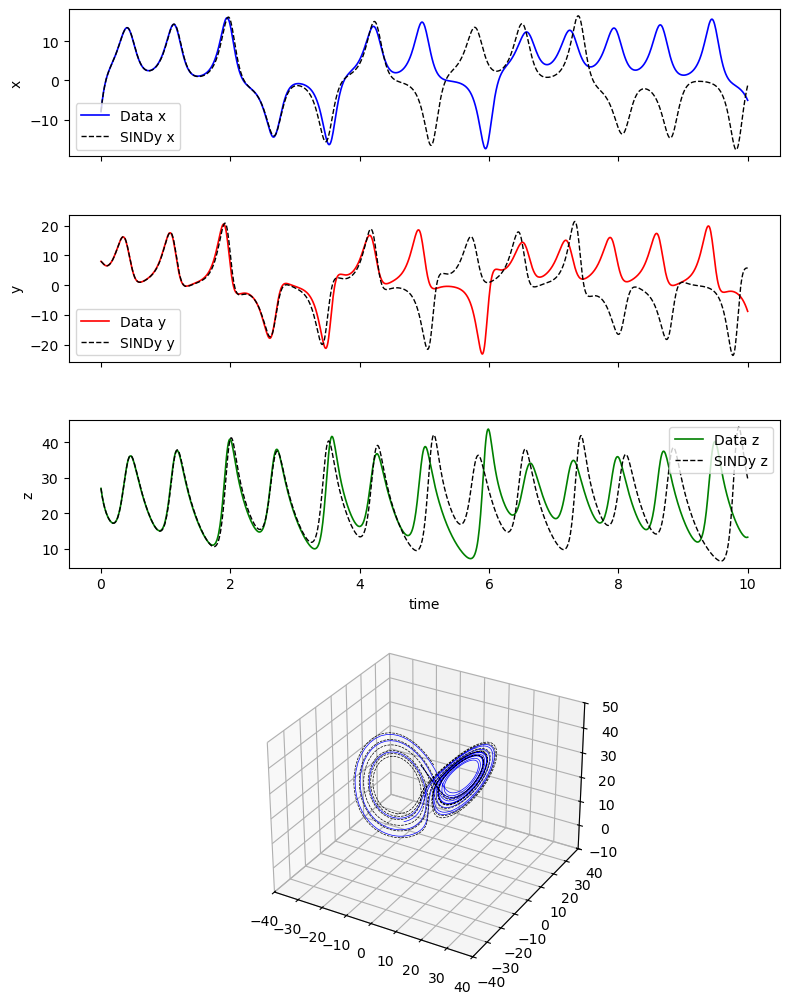

In [4]:
# ------------------------------------------------
# 4. Evaluate Performance of SINDy Model for Forecasting
# ------------------------------------------------

# Define the SINDy ODE function for integration
def sindy_ode(t, x, params):
    # This function needs the 'poolData' and 'xi' from the main script
    theta_ode = poolData(x, params['polyorder'])
    dx = (theta_ode @ params['xi']).flatten()
    return dx

    
# Package parameters for the ODE solver
sindy_params = {'xi': xi, 'polyorder': polyorder}

# Simulate the learned model
sindy_solution = solve_ivp(
    fun=sindy_ode,
    t_span=t_span,
    y0=x0,
    args=(sindy_params,),
    t_eval=t_eval
)

x_sindy_sim = sindy_solution.y.T

# Plot the comparison between the original data and the SINDy prediction
plot_sindy(t_eval, x_true, t_eval, x_sindy_sim)